# Trying out Theano

Based on the [work by Jason Baldridge](https://bcomposes.wordpress.com/2015/11/26/simple-end-to-end-tensorflow-examples/) and on previous experiments with TensorFlow, Google's newly open-sourced data analysis library, I am going to try out [Theano](http://deeplearning.net/software/theano/).

In [1]:
import theano
import theano.tensor as T

We will use a few functions from [`scikit-learn`](http://scikit-learn.org) to generate data sets:

In [2]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cross_validation import train_test_split

Numpy and Matplotlib are always good to have...

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

But the default style for plots in MPL is not beautiful enough, so we use another style:

In [4]:
mpl.style.use('fivethirtyeight')

We'll also set up some configuration variables up-front:

In [5]:
# Configuration variables:
num_labels = 2    # The number of labels.
NUM_EPOCHS = 5
NUM_HIDDEN = 5
BATCH_SIZE = 100  # The number of training examples to use per training step.
n_train = 1000
n_test = 200

And set up a function to generate datasets from functions in `scikit-learn`:

In [6]:
def generate_dataset(func, n_train=n_train, n_test=n_test, num_labels=num_labels, **kwargs):
    """ Create synthetic classification data-sets
    
    Parameters 
    ----------
    func : one of {`make_blobs`, `make_circles`, `make_moons`}
        What kind of data to make.
    n_train : int
        The size of the training set.
    n_test : int
        The size of the test set.
    num_labels : int
        The number of classes.
    
    Returns
    -------
    train_data, test_data : 2D arrays
        Dimensions: {n_train, n_test} by 2
    train_labels, test_labels: one-hot encoder arrays
        These have dimensions {n_train, n_test} by num_labels
    """
    fvecs, labels = func(n_train + n_test, **kwargs)
    # We need the one-hot encoder!
    labels_onehot = (np.arange(num_labels) == labels[:, None])
    train_data, test_data, train_labels, test_labels = train_test_split(fvecs.astype(np.float32), 
                                                                        labels_onehot.astype(np.float32), 
                                                                        train_size=n_train)
    return train_data, test_data, train_labels, test_labels 

### The first example is a linearly separable data-set:

In [7]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_blobs, n_train=1000, n_test=200, 
                                                                    centers=2, center_box=[-4., 4.])

In [8]:
train_labels.shape

(1000, 2)

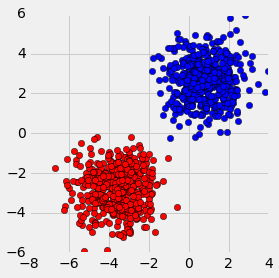

In [9]:
fig, ax = plt.subplots(1)
ax.plot(train_data[np.where(train_labels[:, 0]), 0], train_data[np.where(train_labels[:, 0]), 1], 'bo')
ax.plot(train_data[np.where(train_labels[:, 1]), 0], train_data[np.where(train_labels[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [10]:
a = theano.tensor.vector() # declare variable
b = theano.tensor.vector() # declare variable

out = a ** 2 + b ** 2 + 2 * a * b            # build symbolic expression
f = theano.function([a, b], out)   # compile function

print(f([0, 1, 2], [0, 1, 2]))


[  0.   4.  16.]


In [11]:
train_size, num_features = train_data.shape
train_size, num_labels = train_labels.shape

x = T.vector()
y = T.vector()

W = theano.shared(np.zeros([num_features, num_labels]))
b = theano.shared(np.zeros([num_labels]))

In [12]:
T.sum

<function theano.tensor.basic.sum>

In [13]:
def train_softmax(train_data, train_labels,
                  batch_size=BATCH_SIZE,
                  num_epochs=NUM_EPOCHS):
    """ 
    Train a softmax network with cross-entropy penalty
    
    Parameters
    ----------
    train_data, train_labels: output of `generate_dataset`.
    batch_size : int
        The number of items in training batch.
    num_epochs : int
        The number of training epochs.
        
    Returns 
    -------
    W : Variable
        The model estimated weight matrix.
    b : Variable
        The model estimated bias vector.
    s : TensorFlow session
        The session in which these variables were defined.
    """
    train_size, num_features = train_data.shape
    train_size, num_labels = train_labels.shape
    x = T.matrix()
    y = T.matrix()

    # The parameters
    W = theano.shared(np.zeros([num_features, num_labels]))
    b = theano.shared(np.zeros([num_labels]))
    # Predict back
    y_hat = T.nnet.softmax(T.dot(x, W) + b)
    cross_entropy = -y * T.log(y_hat) - (1-y) * T.log(1-y_hat) # Cross-entropy loss function
    cost = cross_entropy.mean()  # The cost to minimize
    # The gradients of the function relative to the parameter:
    gw, gb = T.grad(cost, [W, b])    
        
    # Optimization:
    train = theano.function(inputs=[x, y],
                            outputs=[y_hat, cross_entropy],
                            updates=((W, W - 0.1 * gw), (b, b - 0.1 * gb)))
    
    predict = theano.function(inputs=[x], outputs=y_hat)
    
    # Iterate and train:
    print('Training:')
    for step in xrange(num_epochs * train_size // batch_size):
        print(step),

        offset = (step * batch_size) % train_size
        batch_data = train_data[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        pred, err = train(batch_data, batch_labels)

        if offset >= train_size-batch_size:
            print

    return W, b

In [14]:
W, b = train_softmax(train_data, train_labels)

Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


In [15]:
def evaluate_softmax(W, b, test_data, test_labels):
    """ 
    Proportion correct classification in test data of 
    the softmax model.
    
    Parameters
    ----------
    W, b, s : outputs of `train_softmax`
    test_data, test_labels : outputs of `generate_dataset`
    
    Returns 
    -------
    p_correct : float
        The proportion correct classification
    """
    test_size, num_features = test_data.shape
    test_size, num_labels = test_labels.shape
    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = T.matrix('x')
    y = T.matrix('y')
    y_hat = T.nnet.softmax(T.dot(x, W) + b)
    accuracy = T.eq(T.argmax(y_hat, 1), T.argmax(y, 1))
    p_correct = T.mean(accuracy)
    f_p_correct = theano.function([x, y], p_correct)
    p_correct = f_p_correct(test_data, test_labels)
    return p_correct

In [16]:
evaluate_softmax(W, b, test_data, test_labels)

array(1.0)

In [17]:
Wx_b = np.dot(test_data, W.get_value()) + b.get_value()

In [18]:
x = T.matrix('x')
y_hat = T.nnet.softmax(T.dot(x, W) + b)
f = theano.function([x], y_hat)
cls = f(test_data)

In [19]:
cls_np = np.round(cls)

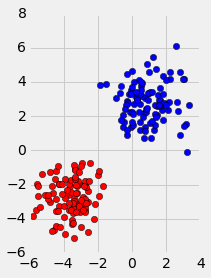

In [20]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls_np[:, 0]), 0], test_data[np.where(cls_np[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls_np[:, 1]), 0], test_data[np.where(cls_np[:, 1]), 1], 'ro')
ax.set_aspect('equal')

### The next set of data is not linearly separable:

In [21]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_moons, n_train=1000, n_test=200, noise=0.2)

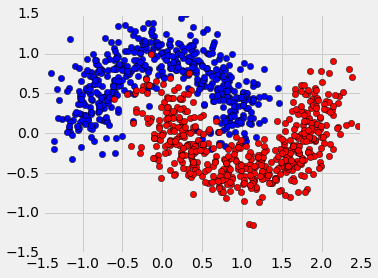

In [22]:
fig, ax = plt.subplots(1)
ax.plot(train_data[np.where(train_labels[:, 0]), 0], train_data[np.where(train_labels[:, 0]), 1], 'bo')
ax.plot(train_data[np.where(train_labels[:, 1]), 0], train_data[np.where(train_labels[:, 1]), 1], 'ro')
ax.set_aspect('equal')

### And softmax doesn't do great:

In [23]:
W, b = train_softmax(train_data, train_labels)
evaluate_softmax(W, b, test_data, test_labels)

Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


array(0.865)

In [24]:
x = T.matrix('x')
y_hat = T.nnet.softmax(T.dot(x, W) + b)
f = theano.function([x], y_hat)
cls = np.round(f(test_data))

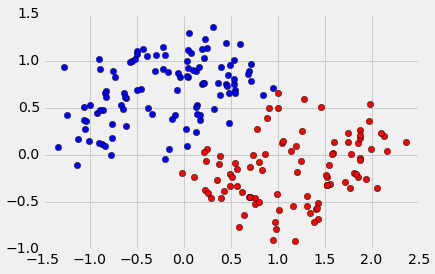

In [25]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [26]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_circles, n_train=1000, n_test=200, noise=0.2, factor=0.1)

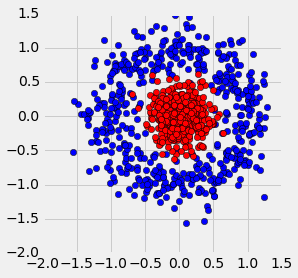

In [27]:
fig, ax = plt.subplots(1)
ax.plot(train_data[np.where(train_labels[:, 0]), 0], train_data[np.where(train_labels[:, 0]), 1], 'bo')
ax.plot(train_data[np.where(train_labels[:, 1]), 0], train_data[np.where(train_labels[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [28]:
W, b  = train_softmax(train_data, train_labels)
evaluate_softmax(W, b, test_data, test_labels)

Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


array(0.33)

In [29]:
x = T.matrix('x')
y_hat = T.nnet.softmax(T.dot(x, W) + b)
f = theano.function([x], y_hat)
cls = np.round(f(test_data))

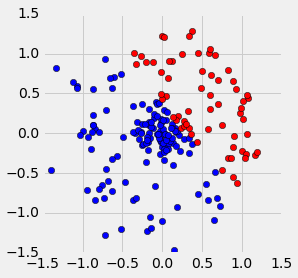

In [30]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

## Another approach is a network with hidden layers

First, we will define a helper function that helps us initialize the weights in networks with hidden layers. This strategy was proposed in a [paper](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf) by Xavier Glorot and Yoshua Bengio, and is explained in this [blog post](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

The implementation is based on code by Delip Rao (https://github.com/delip/blog-stuff/blob/master/tensorflow_ufp.ipynb)


In [31]:
def init_weights(shape, init_method='xavier', xavier_params = (None, None)):
    """ Initialization of weights in a multi-layer network 
    
    Parameters
    ----------
    shape : list or tuple
        The shape of the weight matrix
    init_method: str, one of {'xavier', 'zeros', 'uniform'}
        The initialization method for the weights. 
           'xavier' : uses the method developed by Glorot and Bengio.
           'zeros' : set all weights to zeros.
           'uniform' : weights drawn from uniform distribution [0, 1].
    xavier_params : list or tuple of length 2
        fan_in and fan_out ratios for this layer
    """    
    if init_method == 'zeros':
        return theano.shared(np.zeros(shape))
    elif init_method == 'uniform':
        return theano.shared(np.random.uniform(size=shape))
    else: #xavier
        (fan_in, fan_out) = xavier_params
        low = -4*np.sqrt(6.0/(fan_in + fan_out)) # {sigmoid:4, tanh:1} 
        high = 4*np.sqrt(6.0/(fan_in + fan_out))
        return theano.shared(np.random.uniform(low=low, high=high, size=shape))
    

In [32]:
def train_hidden(train_data, 
                 train_labels, 
                 batch_size=BATCH_SIZE,
                 num_epochs=NUM_EPOCHS, 
                 num_hidden=NUM_HIDDEN):
    """ 
    Train a network with one hidden layer
    
    Parameters
    ----------
    train_data, train_labels: output of `generate_dataset`.
    batch_size : int
        The number of items in training batch.
    num_epochs : int
        The number of training epochs.
        
    Returns
    -------
    w_hidden, b_hidden, w_out, b_out : Variable 
        Weights and biases for the hidden and output layer.
    s : TensorFlow session
    """
    # Get the shape of the training data.
    train_size, num_features = train_data.shape
    train_size, num_labels = train_labels.shape

    x = T.matrix()
    y = T.matrix()
    
    # Initialize the hidden weights and biases.
    w_hidden = init_weights([num_features, num_hidden],
                             'xavier',
                             xavier_params=(num_features, num_hidden))

    b_hidden = init_weights([num_hidden],'zeros')

    # The hidden layer.
    hidden = T.tanh(T.dot(x, w_hidden) + b_hidden)

    # Initialize the output weights and biases.
    w_out = init_weights([num_hidden, num_labels],
                          'xavier',
                          xavier_params=(num_hidden, num_labels))
    
    b_out = init_weights([num_labels],'zeros')

    # The output layer.
    y_hat = T.nnet.softmax(T.dot(hidden, w_out) + b_out)
    
    cross_entropy = -y * T.log(y_hat) - (1-y) * T.log(1-y_hat) # Cross-entropy loss function
    cost = cross_entropy.mean()  # The cost to minimize
    # The gradients of the function relative to the parameter:
    gw_h, gb_h, gw_o, gb_o = T.grad(cost, [w_hidden, b_hidden, w_out, b_out])    

    train = theano.function(inputs=[x, y],
                            outputs=[y_hat, cross_entropy],
                            updates=((w_hidden, w_hidden - 0.1 * gw_h), 
                                     (b_hidden, b_hidden - 0.1 * gb_h),
                                     (w_out, w_out - 0.1 * gw_o), 
                                     (b_out, b_out - 0.1 * gb_o)))
    
    predict = theano.function(inputs=[x], outputs=y_hat)
    
    # Iterate and train:
    print('Training:')
    for step in xrange(num_epochs * train_size // batch_size):
        print(step),

        offset = (step * batch_size) % train_size
        batch_data = train_data[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        pred, err = train(batch_data, batch_labels)

        if offset >= train_size-batch_size:
            print

    return w_hidden, b_hidden, w_out, b_out

In [33]:
def evaluate_hidden(w_hidden, b_hidden, w_out, b_out, test_data, test_labels):
    """ 
    Evaluate the parameters of a network with one hidden layer on test data
    
    Parameters
    ----------
    w_hidden, b_hidden, w_out, b_out, s : outputs of `train_hidden`
    test_data, test_labels : outputs of `generate_dataset`
    
    Returns 
    -------
    p_correct : float
        The proportion correct classification
    
    """
    
    test_size, num_features = test_data.shape
    test_size, num_labels = test_labels.shape
    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = T.matrix('x')
    y = T.matrix('y')
    
    
    hidden = T.tanh(T.dot(x, w_hidden) + b_hidden)
    y_hat = T.nnet.softmax(T.dot(hidden, w_out) + b_out)
    accuracy = T.eq(T.argmax(y_hat, 1), T.argmax(y, 1))
    p_correct = T.mean(accuracy)
    f_p_correct = theano.function([x, y], p_correct)
    p_correct = f_p_correct(test_data, test_labels)
    return p_correct

In [34]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_circles, n_train=1000, n_test=200, noise=0.2, factor=0.1)

In [35]:
w_hidden, b_hidden, w_out, b_out  = train_hidden(train_data, train_labels)
evaluate_hidden(w_hidden, b_hidden, w_out, b_out, test_data, test_labels)

Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


array(0.8)

In [36]:
x = T.matrix('x')
hidden = T.tanh(T.dot(x, w_hidden) + b_hidden)
y_hat = T.nnet.softmax(T.dot(hidden, w_out) + b_out)
f = theano.function([x], y_hat)
cls = np.round(f(test_data))

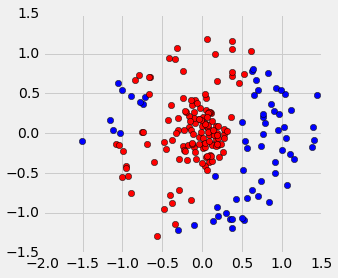

In [37]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [40]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_moons, n_train=1000, n_test=200, noise=0.2)

In [41]:
w_hidden, b_hidden, w_out, b_out = train_hidden(train_data, train_labels)
evaluate_hidden(w_hidden, b_hidden, w_out, b_out, test_data, test_labels)

Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


array(0.83)

In [42]:
x = T.matrix('x')
hidden = T.tanh(T.dot(x, w_hidden) + b_hidden)
y_hat = T.nnet.softmax(T.dot(hidden, w_out) + b_out)
f = theano.function([x], y_hat)
cls = np.round(f(test_data))

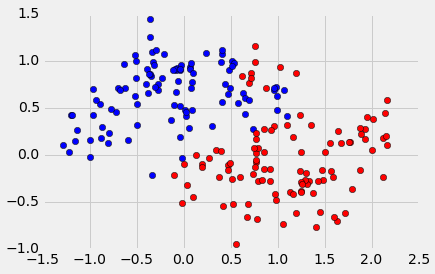

In [43]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

## Next, we build a "universal function approximator" out of a similar network

As implied above, neural networks with hidden layers can do *any* classification task. Moving 
from the world of classification to regression, an even more general statement is that they can be used to 
approximate any function (!). An intuitive explanation of this fact can be read [here](http://neuralnetworksanddeeplearning.com/chap4.html).

Let's go ahdead and build a Universal Function Approximator, based on code in [a notebook by Delip Rao](https://github.com/delip/blog-stuff/blob/master/tensorflow_ufp.ipynb).

In [44]:
class UniversalFunctionApproximator(object):
    """ Approximate any function using a neural network with a hidden layer"""
    def __init__(self, 
                 n_hidden=NUM_HIDDEN, 
                 batch_size=BATCH_SIZE,
                 n_epochs=NUM_EPOCHS):
        """ Initialize a UniversalFunctionApproximator
        
        Parameters
        ----------
        n_hidden : number of units in the hidden layer
        batch_size : how many samples in each batch ("mini batch") in training
        n_epochs : how many rounds of training
        """
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        # Initialize the weights for both layers:
        self.w_h = init_weights([n_hidden], 'xavier', xavier_params=(1, n_hidden))
        self.b_h = init_weights([n_hidden], 'zeros')
        self.w_o = init_weights([n_hidden], 'xavier', xavier_params=(n_hidden, 1))
        self.b_o = init_weights([1], 'zeros')
        
    def _ann(self, X):    
        """A two-layer network"""
        h = T.nnet.sigmoid(T.dot(X, self.w_h) + self.b_h)
        return T.dot(h, self.w_o) + self.b_o

    def fit(self, trainx, trainy):
        """ 
        Fit a UFA to data
        
        Parameters
        ----------
        trainx, trainy : 1D arrays
            x,y values of the data.
        """
        
        x = tf.placeholder(tf.float32, [None, 1], name="X")
        y = tf.placeholder(tf.float32, [None, 1], name="Y")
        y_hat = self._ann(x)
        #cross_entropy = -tf.reduce_sum(y * tf.log(y_hat))
        #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
        train_step = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(y_hat - y))
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())
        for i in range(self.n_epochs):
            for start, end in zip(range(0, len(trainx), self.batch_size), 
                                  range(self.batch_size, len(trainx), self.batch_size)):
                self.sess.run(train_step, feed_dict={x: trainx[start:end], y: trainy[start:end]})

    def predict(self, testx):
        """ 
        Predict y from x 
        
        Parameters
        ----------
        testx : 1D array
            x values to predict from.
        """
        try:
            return self.sess.run(self._ann(testx))
        except AttributeError:
            raise AttributeError("You need to run `fit` befor you can predict!")

In [ ]:
function_to_learn = lambda x: np.sin(x) + 0.1 * np.random.randn(*x.shape)

In [ ]:
ufa = UniversalFunctionApproximator(n_hidden=100)

In [ ]:
num_examples = 1000000
train_split = 0.99

In [ ]:
all_x = np.float32(np.random.uniform(-2*np.pi, 2*np.pi, (1, num_examples))).T
np.random.shuffle(all_x)

train_size = int(num_examples*train_split)

trainx = all_x[:train_size]
testx = all_x[train_size:]

trainy = function_to_learn(trainx)
testy = function_to_learn(testx)

In [ ]:
ufa.fit(trainx, trainy)

In [ ]:
y_hat = ufa.predict(testx)

In [ ]:
plt.plot(testx, testy, '.')
plt.plot(testx, y_hat, '.')

## Let's do something useful

Building on top of what we've already done, let's try to do something useful. Like recognize hand-written digits in the MNIST data set:

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [ ]:
data, labels = mnist.data, mnist.target

In [ ]:
labels_onehot = (np.arange(10) == labels[:, None])

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_onehot, train_size=0.9)

In [ ]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
s.run(tf.initialize_all_variables())
y = tf.nn.softmax(tf.matmul(x,W) + b)
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
s.run(tf.initialize_all_variables())

for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, train_accuracy)
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print "test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})

In building a convolutional neural network, we want to apply convolution and max pooling operations:

In [ ]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], 
                        padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, 
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], 
                          padding='SAME')

In [ ]:
def train_dnn(train_data, 
              train_labels, 
              batch_size=BATCH_SIZE,
              num_epochs=NUM_EPOCHS, 
              num_hidden=NUM_HIDDEN,
              sess=s,
              num_hidden1=32,
              num_hidden2=128):
    """ 
    Train a network with two hidden layers
    
    Parameters
    ----------
    train_data, train_labels: output of `generate_dataset`.
    batch_size : int
        The number of items in training batch.
    num_epochs : int
        The number of training epochs.
        
    Returns
    -------
    w_hidden, b_hidden, w_out, b_out : Variable 
        Weights and biases for the hidden and output layer.
    s : TensorFlow session
    """
    # Get the shape of the training data.
    train_size, num_features = train_data.shape
    train_size, num_labels = train_labels.shape
    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = tf.placeholder("float", shape=[None, num_features])
    y = tf.placeholder("float", shape=[None, num_labels])
    
    # Initialize the hidden weights and biases.
    w_hidden1 = init_weights(
        [num_features, num_hidden1],
        'xavier',
        xavier_params=(num_features, num_hidden1))

    b_hidden1 = init_weights([1, num_hidden1],'zeros')

    hidden1 = tf.nn.tanh(tf.matmul(x, w_hidden1) + b_hidden1)
    
    # Initialize the hidden weights and biases.
    w_hidden2 = init_weights(
        [num_hidden1, num_hidden2],
        'xavier',
        xavier_params=(num_hidden1, num_hidden2))

    b_hidden2 = init_weights([1, num_hidden2],'zeros')

    # The hidden layer.
    hidden2 = tf.nn.tanh(tf.matmul(hidden1, w_hidden2) + b_hidden2)

    # Initialize the output weights and biases.
    w_out = init_weights(
        [num_hidden2, num_labels],
        'xavier',
        xavier_params=(num_hidden2, num_labels))
    
    b_out = init_weights([1, num_labels],'zeros')

    # The output layer.
    y_hat = tf.nn.softmax(tf.matmul(hidden2, w_out) + b_out)
    
    # Optimization.
    train_step = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(y_hat - y))    
    tf.initialize_all_variables().run(session=sess)
    print 'Initialized!'
    # Iterate and train:
    print('Training.')
    for step in xrange(num_epochs * train_size // batch_size):
        print(step),

        offset = (step * batch_size) % train_size
        batch_data = train_data[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        train_step.run(feed_dict={x: batch_data, y: batch_labels}, session=sess)

        if offset >= train_size-batch_size:
            print
    return w_hidden1, b_hidden1, w_hidden2, b_hidden2, w_out, b_out


In [ ]:
w_hidden1, b_hidden1, w_hidden2, b_hidden2, w_out, b_out = train_dnn(train_data,train_labels)

In [ ]:
def evaluate_dnn(w_hidden1, b_hidden1, w_hidden2, b_hidden2, w_out, b_out, test_data, test_labels, sess=s):
    """ 
    Evaluate the parameters of a network with two hidden layers on test data
    
    Parameters
    ----------
    w_hidden, b_hidden, w_out, b_out, s : outputs of `train_hidden`
    test_data, test_labels : outputs of `generate_dataset`
    
    Returns 
    -------
    p_correct : float
        The proportion correct classification
    
    """
    test_size, num_features = test_data.shape
    test_size, num_labels = test_labels.shape
    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = tf.placeholder("float", shape=[None, num_features])
    y = tf.placeholder("float", shape=[None, num_labels])

    hidden1 = tf.nn.tanh(tf.matmul(x, w_hidden1) + b_hidden1)
    hidden2 = tf.nn.tanh(tf.matmul(hidden1, w_hidden2) + b_hidden2)
    y_hat = tf.nn.softmax(tf.matmul(hidden2, w_out) + b_out)
    
    # Evaluation:
    correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    p_correct = accuracy.eval(feed_dict={x: test_data, y: test_labels}, session=sess)
    return p_correct


In [ ]:
evaluate_dnn(w_hidden1, b_hidden1, w_hidden2, b_hidden2, w_out, b_out, test_data, test_labels, sess=s)

In [ ]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
s.run(tf.initialize_all_variables())
y = tf.nn.softmax(tf.matmul(x,W) + b)
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
s.run(tf.initialize_all_variables())

for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print "step %d, training accuracy %g"%(i, train_accuracy)
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print "test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})